In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
# # import tensorflow as tf
# # import seaborn as sns
# # tf.test.gpu_device_name()
# import torch
# import random
# seed = 12
# # torch.manual_seed(seed)
# # torch.cuda.manual_seed(seed)
# # torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# random.seed(seed)
# # torch.backends.cudnn.benchmark = False
# # torch.use_deterministic_algorithms(True)

In [112]:
label = pd.read_csv("../data/Archive/Cooking Game Suggested Tips  - BBS21-Phase2-Disruption.csv")
label = label[label["treatment"] == "control"]
label

,ResponseId,MID,treatment,t1,t2,t3,t4,t1n,t2n,average score,...,post_edu,post_strategy,post_strategy2,post_prioritize,post_change2,Group #,Dim. 1,Dim. 2 (Advantage),Dim. 3 (Explanation),Dim. 4 (Negative / Positive)
271,R_0DNcJqALC3UG9Db,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,24.0,24.0,35.500000,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
272,R_0HbfbDtnkUIRbvH,A367F6VZYAOLU,control,38.0,41.0,38.0,36.0,22.0,24.0,33.166667,...,4 year degree,practice,"Keep all workers busy,Learn who is faster at w...",everyone had to be working,"similar strategy, sous chef also plates",3.0,P4,A2,E0,N0
273,R_0cVkkjfJMy8V6P7,A2Y0WNHMT4PZ4C,control,38.0,38.0,38.0,38.0,28.0,24.0,34.000000,...,Some college,Made sure each worker had work on each tick,Keep all workers busy,I tried to give the work to the worker with th...,I tried to give the biggest job (cooking) to t...,3.0,K4,A0,E0,N0
274,R_10OZ3Fgz4TJo8Vx,ADKJBYY9Q3VNZ,control,36.0,38.0,38.0,38.0,23.0,23.0,32.666667,...,4 year degree,Try to allocate resources to the best option,"Keep all workers busy,Intentionally leave some...",I made them multi task by not assigning specif...,I assigned more work to the sous chef and the ...,2.0,NaN,NaN,NaN,N0
275,R_11WSDnMOeKXakQH,AT8SAYP8NDPYA,control,44.0,39.0,38.0,41.0,25.0,24.0,35.166667,...,Professional degree,Assigned work based on their title,Keep all workers busy,Give work based on their work experience,No,2.0,NaN,NaN,NaN,N0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,R_xlnJEPOkxxHspJT,A2MD8YUPQK8S2H,control,38.0,37.0,38.0,38.0,21.0,20.0,32.000000,...,4 year degree,Try different combinations,"Keep all workers busy,Intentionally leave some...","Whichever workers took less ticks, i would use...",I had to give Server more of the cooking centr...,2.0,NaN,NaN,NaN,N0
511,R_yNJaIImQ7EY3J5v,A2TLTOOOOP48UQ,control,38.0,36.0,37.0,36.0,20.0,20.0,31.166667,...,Some college,To make combinations to get the best outcome,"Intentionally leave some workers idle,Learn wh...",I made sure to see the duration of turns that ...,I changed it by counting the turns that the so...,2.0,NaN,NaN,NaN,N0
512,R_yqY6xKo4dUHco6d,A1ODKX8APG7Q9J,control,38.0,35.0,35.0,35.0,21.0,20.0,30.666667,...,4 year degree,Make sure to give jobs to the ones who do them...,"Intentionally leave some workers idle,Assign t...",Make sure the longest jobs go to the chef and ...,I made sure everyone was busy most of the time...,3.0,K1,D0,E0,N0
513,R_yrKr3inrXDL5Lvb,A2PK2UX3AECX9U,control,38.0,39.0,40.0,42.0,23.0,20.0,33.666667,...,Professional degree,to give the tasks to the worker who complete i...,Learn who is faster at what first and then ass...,By the number of ticks left,I tried to disburse the tasks evenly,3.0,K4,D0,E0,N0


### Generate Embedding

In [32]:
import ast
class allaction():
    
    def __init__(self, file):
        self.df = pd.read_csv(file) 
        # self.df = self.sdf.sample(frac=1, random_state=42).reset_index().drop("index", axis=1)
        self.orderId, self.taskId, self.taskTicks, self.workerId, self.workerTicks = [], [], [], [], []
        self.ResponseId, self.Round, self.Tick = [], [], []
    #taskId: 0~idle, 1~chop, 2~cook, 3~plate
    #workerId: 0~chef, 1~sou-chef, 2~server
    #           0~sou-chef, 1~server, CHANGE!!! 0~idle, 1~chef, 2~sou-chef, 3~server
    
    def parse(self):
        # all id + 1, leaving 0 to be idle
        action = self.df
        for i in tqdm(np.arange(action.shape[0])):
            row = action.iloc[i,:]
            for act in ["action1", "action2", "action3"]:
                # when there is no action in this act
                if type(row[act]) != str:
                    self.orderId.append(0)
                    self.taskId.append(0)
                    self.taskTicks.append(0)
                    self.workerId.append(0)
                    self.workerTicks.append(0)
                else:
                    a = ast.literal_eval(row[act])
                    self.orderId.append(a["order_id"] + 1)
                    self.taskId.append(a["task_id"] + 1)
                    self.taskTicks.append(a["task_ticks"])
                    self.workerId.append(a["worker_id"] + 1)
                    self.workerTicks.append(a["worker_ticks"])

                self.ResponseId.append(row["ResponseId"])
                self.Round.append(row["round"])
                self.Tick.append(row["tick"])
                
    def get(self):
        self.parse()
        d = {
            "ResponseId": self.ResponseId,
            "round": self.Round,
            "tick": self.Tick,
            "orderId": self.orderId, 
            "taskId": self.taskId, 
            "taskTicks": self.taskTicks, 
            "workerId": self.workerId, 
            "workerTicks": self.workerTicks
        }
        return pd.DataFrame(d)

In [113]:
label["treatment"].unique()

array(['control'], dtype=object)

In [114]:
file =  "../data/Archive/phase2_action.csv"
action = allaction(file).get()
action = action[action["round"] <= 2]
action = action.drop("workerTicks", axis=1)
# label=pd.read_csv( "../data/Archive/Cooking Game Suggested Tips  - BBS21-Phase2-Disruption.csv")
action = action.merge(label,how = "inner",
            left_on="ResponseId", right_on="ResponseId")
action = action.rename(columns = {"Group #":"label"})

100%|███████████████████████████████████████████████████████████████████████████████████████| 195642/195642 [00:13<00:00, 15004.24it/s]


In [115]:
y = action.groupby("ResponseId").agg(np.mean)["label"].astype(int)            
action            

,ResponseId,round,tick,orderId,taskId,taskTicks,workerId,MID,treatment,t1,...,post_edu,post_strategy,post_strategy2,post_prioritize,post_change2,label,Dim. 1,Dim. 2 (Advantage),Dim. 3 (Explanation),Dim. 4 (Negative / Positive)
0,R_0DNcJqALC3UG9Db,1,1,1,1,2,1,A2XMNG4YU43G39,control,38.0,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
1,R_0DNcJqALC3UG9Db,1,1,2,1,2,2,A2XMNG4YU43G39,control,38.0,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
2,R_0DNcJqALC3UG9Db,1,1,3,1,2,3,A2XMNG4YU43G39,control,38.0,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
3,R_0DNcJqALC3UG9Db,1,2,0,0,0,0,A2XMNG4YU43G39,control,38.0,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
4,R_0DNcJqALC3UG9Db,1,2,0,0,0,0,A2XMNG4YU43G39,control,38.0,...,2 year degree,First few rounds it worked out and the last fe...,"Keep all workers busy,Assign the same task to ...",I changed how to have the help do work and it ...,I realized that you can not leave another play...,2.0,NaN,NaN,NaN,N1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32653,R_z6DSJfELElPHABP,2,19,0,0,0,0,A1ZYTJAQNS5ICC,control,41.0,...,Some college,My strategy was to make sure the workers got j...,Learn who is faster at what first and then ass...,I gave the workers tasks that minimized the am...,I had to be much more careful with what tasks ...,3.0,D1,A2,E0,N0
32654,R_z6DSJfELElPHABP,2,19,0,0,0,0,A1ZYTJAQNS5ICC,control,41.0,...,Some college,My strategy was to make sure the workers got j...,Learn who is faster at what first and then ass...,I gave the workers tasks that minimized the am...,I had to be much more careful with what tasks ...,3.0,D1,A2,E0,N0
32655,R_z6DSJfELElPHABP,2,20,4,3,2,3,A1ZYTJAQNS5ICC,control,41.0,...,Some college,My strategy was to make sure the workers got j...,Learn who is faster at what first and then ass...,I gave the workers tasks that minimized the am...,I had to be much more careful with what tasks ...,3.0,D1,A2,E0,N0
32656,R_z6DSJfELElPHABP,2,20,0,0,0,0,A1ZYTJAQNS5ICC,control,41.0,...,Some college,My strategy was to make sure the workers got j...,Learn who is faster at what first and then ass...,I gave the workers tasks that minimized the am...,I had to be much more careful with what tasks ...,3.0,D1,A2,E0,N0


In [116]:
t1 = action.drop("orderId", axis=1)
t2 = t1.merge(pd.get_dummies(t1["taskId"]), left_index=True, right_index=True).drop("taskId", axis=1).rename(
    columns={0:"idle", 1:"chop", 2:"cook", 3:"plate"})
df = t2.merge(pd.get_dummies(t2["workerId"]), left_index=True, right_index=True).drop("workerId", axis=1).rename(
    columns={0:"idle", 1:"chef", 2:"sou-chef", 3:"server"})
# df = df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick"]).sum().iloc[:,1:]
df

,ResponseId,round,tick,taskTicks,MID,treatment,t1,t2,t3,t4,...,Dim. 3 (Explanation),Dim. 4 (Negative / Positive),idle,chop,cook,plate,idle,chef,sou-chef,server
0,R_0DNcJqALC3UG9Db,1,1,2,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,...,NaN,N1,0,1,0,0,0,1,0,0
1,R_0DNcJqALC3UG9Db,1,1,2,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,...,NaN,N1,0,1,0,0,0,0,1,0
2,R_0DNcJqALC3UG9Db,1,1,2,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,...,NaN,N1,0,1,0,0,0,0,0,1
3,R_0DNcJqALC3UG9Db,1,2,0,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,...,NaN,N1,1,0,0,0,1,0,0,0
4,R_0DNcJqALC3UG9Db,1,2,0,A2XMNG4YU43G39,control,38.0,40.0,42.0,45.0,...,NaN,N1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32653,R_z6DSJfELElPHABP,2,19,0,A1ZYTJAQNS5ICC,control,41.0,38.0,38.0,36.0,...,E0,N0,1,0,0,0,1,0,0,0
32654,R_z6DSJfELElPHABP,2,19,0,A1ZYTJAQNS5ICC,control,41.0,38.0,38.0,36.0,...,E0,N0,1,0,0,0,1,0,0,0
32655,R_z6DSJfELElPHABP,2,20,2,A1ZYTJAQNS5ICC,control,41.0,38.0,38.0,36.0,...,E0,N0,0,0,0,1,0,0,0,1
32656,R_z6DSJfELElPHABP,2,20,0,A1ZYTJAQNS5ICC,control,41.0,38.0,38.0,36.0,...,E0,N0,1,0,0,0,1,0,0,0


In [117]:
a = df.drop("taskTicks", axis=1)
X = a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[0]).merge(
    a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[1]).merge(
        a.groupby(["ResponseId", "round", "tick", "label"]).agg(lambda x: x.iloc[2])
    , left_index=True, right_index=True), left_index=True, right_index=True)
X    

MID treatment    t1    t2  \
ResponseId        round tick label                                         
R_0DNcJqALC3UG9Db 1     1    2.0    A2XMNG4YU43G39   control  38.0  40.0   
                        2    2.0    A2XMNG4YU43G39   control  38.0  40.0   
                        3    2.0    A2XMNG4YU43G39   control  38.0  40.0   
                        4    2.0    A2XMNG4YU43G39   control  38.0  40.0   
                        5    2.0    A2XMNG4YU43G39   control  38.0  40.0   
...                                            ...       ...   ...   ...   
R_z6DSJfELElPHABP 2     16   3.0    A1ZYTJAQNS5ICC   control  41.0  38.0   
                        17   3.0    A1ZYTJAQNS5ICC   control  41.0  38.0   
                        18   3.0    A1ZYTJAQNS5ICC   control  41.0  38.0   
                        19   3.0    A1ZYTJAQNS5ICC   control  41.0  38.0   
                        20   3.0    A1ZYTJAQNS5ICC   control  41.0  38.0   

                                      t3    t4   t1n   t2n  average score  \
ResponseId        round tick label                                          
R_0DNcJqALC3UG9Db 1     1    2.0    42.0  45.0  24.0  24.0      35.500000   
                        2    2.0    42.0  45.0  24.0  24.0      35.500000   
                        3    2.0    42.0  45.0  24.0  24.0      35.500000   
                        4    2.0    42.0  45.0  24.0  24.0      35.500000   
                        5    2.0    42.0  45.0  24.0  24.0      35.500000   
...                                  ...   ...   ...   ...            ...   
R_z6DSJfELElPHABP 2     16   3.0    38.0  36.0  26.0  21.0      33.333333   
                        17   3.0    38.0  36.0  26.0  21.0      33.333333   
                        18   3.0    38.0  36.0  26.0  21.0      33.333333   
                        19   3.0    38.0  36.0  26.0  21.0      33.333333   
                        20   3.0    38.0  36.0  26.0  21.0      33.333333   

                                                                             best_tip  \
ResponseId        round tick label                                                      
R_0DNcJqALC3UG9Db 1     1    2.0    Keep everyone busy at all time / Do not leave ...   
                        2    2.0    Keep everyone busy at all time / Do not leave ...   
                        3    2.0    Keep everyone busy at all time / Do not leave ...   
                        4    2.0    Keep everyone busy at all time / Do not leave ...   
                        5    2.0    Keep everyone busy at all time / Do not leave ...   
...                                                                               ...   
R_z6DSJfELElPHABP 2     16   3.0    Server should do all plating / Sous-Chef shoul...   
                        17   3.0    Server should do all plating / Sous-Chef shoul...   
                        18   3.0    Server should do all plating / Sous-Chef shoul...   
                        19   3.0    Server should do all plating / Sous-Chef shoul...   
                        20   3.0    Server should do all plating / Sous-Chef shoul...   

                                    ... Dim. 3 (Explanation)_y  \
ResponseId        round tick label  ...                          
R_0DNcJqALC3UG9Db 1     1    2.0    ...                    NaN   
                        2    2.0    ...                    NaN   
                        3    2.0    ...                    NaN   
                        4    2.0    ...                    NaN   
                        5    2.0    ...                    NaN   
...                                 ...                    ...   
R_z6DSJfELElPHABP 2     16   3.0    ...                     E0   
                        17   3.0    ...                     E0   
                        18   3.0    ...                     E0   
                        19   3.0    ...                     E0   
                        20   3.0    ...                     E0   

                                   Dim.

In [118]:
# chop0, chef0, server3
embeddings = []
for i in tqdm(np.arange(X.shape[0])):
    embedding = [0,0,0,0,0,0,0,0,0]
    thisline = X.iloc[i,:]
    
    if thisline["chop"] and thisline["chef"]:
        embedding[0] = 1
    elif thisline["chop"] and thisline["sou-chef"]:
        embedding[1] = 1
    elif thisline["chop"] and thisline["server"]:
        embedding[2] = 1 
    elif thisline["cook"] and thisline["chef"]:
        embedding[3] = 1 
    elif thisline["cook"] and thisline["sou-chef"]:
        embedding[4] = 1
    elif thisline["cook"] and thisline["server"]:
        embedding[5] = 1 
    elif thisline["plate"] and thisline["chef"]:
        embedding[6] = 1 
    elif thisline["plate"] and thisline["sou-chef"]:
        embedding[7] = 1
    elif thisline["plate"] and thisline["server"]:
        embedding[8] = 1 
        
    if thisline["chop_x"] and thisline["chef_x"]:
        embedding[0] = 1
    elif thisline["chop_x"] and thisline["sou-chef_x"]:
        embedding[1] = 1
    elif thisline["chop_x"] and thisline["server_x"]:
        embedding[2] = 1 
    elif thisline["cook_x"] and thisline["chef_x"]:
        embedding[3] = 1 
    elif thisline["cook_x"] and thisline["sou-chef_x"]:
        embedding[4] = 1
    elif thisline["cook_x"] and thisline["server_x"]:
        embedding[5] = 1 
    elif thisline["plate_x"] and thisline["chef_x"]:
        embedding[6] = 1 
    elif thisline["plate_x"] and thisline["sou-chef_x"]:
        embedding[7] = 1
    elif thisline["plate_x"] and thisline["server_x"]:
        embedding[8] = 1         
        
    if thisline["chop_y"] and thisline["chef_y"]:
        embedding[0] = 1
    elif thisline["chop_y"] and thisline["sou-chef_y"]:
        embedding[1] = 1
    elif thisline["chop_y"] and thisline["server_y"]:
        embedding[2] = 1 
    elif thisline["cook_y"] and thisline["chef_y"]:
        embedding[3] = 1 
    elif thisline["cook_y"] and thisline["sou-chef_y"]:
        embedding[4] = 1
    elif thisline["cook_y"] and thisline["server_y"]:
        embedding[5] = 1 
    elif thisline["plate_y"] and thisline["chef_y"]:
        embedding[6] = 1 
    elif thisline["plate_y"] and thisline["sou-chef_y"]:
        embedding[7] = 1
    elif thisline["plate_y"] and thisline["server_y"]:
        embedding[8] = 1  
    
    embeddings.append(embedding)
   

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10886/10886 [00:01<00:00, 6241.88it/s]


In [119]:
kkk = df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick", "label"]).sum().iloc[:,1:]
kkk["index"] = np.arange(kkk.shape[0])
X = kkk.merge(pd.DataFrame(np.array(embeddings)),how="left", left_on="index", right_index=True).drop(
    "chop", axis=1).drop("cook", axis=1).drop("plate", axis=1).drop("idle", axis=1).drop(
    "chef", axis=1).drop("sou-chef", axis=1).drop("server", axis=1).drop("index", axis=1)
X = X.reset_index()
X

,ResponseId,round,tick,label,t2,t3,t4,t1n,t2n,average score,0,1,2,3,4,5,6,7,8
0,R_0DNcJqALC3UG9Db,1,1,2.0,120.0,126.0,135.0,72.0,72.0,106.5,1,1,1,0,0,0,0,0,0
1,R_0DNcJqALC3UG9Db,1,2,2.0,120.0,126.0,135.0,72.0,72.0,106.5,0,0,0,0,0,0,0,0,0
2,R_0DNcJqALC3UG9Db,1,3,2.0,120.0,126.0,135.0,72.0,72.0,106.5,0,0,0,1,0,0,0,0,0
3,R_0DNcJqALC3UG9Db,1,4,2.0,120.0,126.0,135.0,72.0,72.0,106.5,0,0,0,0,1,0,0,0,0
4,R_0DNcJqALC3UG9Db,1,5,2.0,120.0,126.0,135.0,72.0,72.0,106.5,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,R_z6DSJfELElPHABP,2,16,3.0,114.0,114.0,108.0,78.0,63.0,100.0,0,0,0,0,0,0,0,0,0
10882,R_z6DSJfELElPHABP,2,17,3.0,114.0,114.0,108.0,78.0,63.0,100.0,0,0,0,0,0,0,0,0,0
10883,R_z6DSJfELElPHABP,2,18,3.0,114.0,114.0,108.0,78.0,63.0,100.0,0,0,0,0,0,0,0,0,0
10884,R_z6DSJfELElPHABP,2,19,3.0,114.0,114.0,108.0,78.0,63.0,100.0,0,0,0,0,0,0,0,0,0


In [120]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

(array([80., 59., 55., 17., 11.,  6.,  6.,  3.,  2.,  3.]),
 array([38. , 41.4, 44.8, 48.2, 51.6, 55. , 58.4, 61.8, 65.2, 68.6, 72. ]),
 <BarContainer object of 10 artists>)

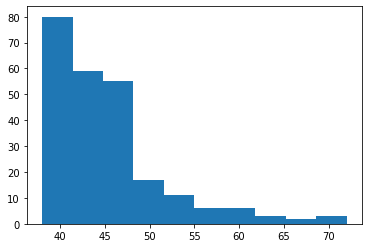

In [121]:
import matplotlib.pyplot as plt
plt.hist(X.groupby("ResponseId").count()["round"])

In [122]:
data = []
MAX_TIME_TICK = max(X.groupby("ResponseId").count()["round"])
MAX_TIME_TICK = 75
for player in tqdm(set(X["ResponseId"])):
    batch = np.array(X[X["ResponseId"] == player].iloc[:MAX_TIME_TICK,10:]).tolist()
    padding = MAX_TIME_TICK - len(batch)
    if padding > 0  :
        for _ in np.arange(padding):
            batch.append([0,0,0,0,0,0,0,0,0])
    data.append(batch)
tensor = np.array(data)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1744.31it/s]


In [123]:
MAX_TIME_TICK

75

### One Hot Encoding

In [124]:
# np.save("onehot.npy", tensor)

In [125]:
# sum(X.groupby("ResponseId").count()["round"] <=50)

### AutoEncoder

In [126]:
# coding: utf-8
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Even if you don't use them, you still have to import
import random
import numpy as np


# Seed
seed = 12
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch 
import torch.nn as nn
X_ac = tensor.reshape(-1,9)
y_ac = tensor.reshape(-1,9)
U = []
for x in X_ac.tolist():
    if x not in U:
        U.append(x)
input_train, output_train = torch.tensor(U[:30], dtype=torch.float), torch.tensor(U[:30], dtype=torch.float)
input_val, output_val = torch.tensor(U[30:], dtype=torch.float), torch.tensor(U[30:], dtype=torch.float)

class autoencoder(nn.Module):
    def __init__(self, hidden_dim=9, s=0):
        super(autoencoder, self).__init__()
        # torch.manual_seed(s)
        self.encoder = nn.Sequential(
                            nn.Linear(9,12),
                            nn.ReLU(),
                            nn.Linear(12,hidden_dim),
    
        )
        self.decoder = nn.Sequential(
                            nn.Linear(hidden_dim,12),
                            nn.ReLU(),
                            nn.Linear(12, 9)
        )                
    def forward(self, x):
        hidden = self.encoder(x)
        out = self.decoder(hidden)
        return hidden, out

def eval(model, X_test, y_test, criterion = nn.MSELoss()):
    # torch.manual_seed(s)
    model.eval()
    with torch.no_grad():
        _, logit = model(X_test)
        loss = criterion(logit, y_test)
    print("loss of model: ", loss.item())  

def train(model, input_train, output_train, criterion = nn.MSELoss(), lr=0.00055):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    # torch.manual_seed(s)
    for epoch in np.arange(6e3):
        _, logit = model(input_train)
        loss = criterion(logit, output_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1e3 == 0:
            print(f"loss of epoch {int(epoch)}: ", loss.item())
            eval(model, input_val, output_val)
            model.train()    
    print("model final loss:")        
    eval(model, input_val, output_val)  
    

model = autoencoder(8)
train(model, input_train, output_train)                       

loss of epoch 0:  0.24626024067401886
loss of model:  0.2902816832065582
loss of epoch 1000:  0.017341842874884605
loss of model:  0.08385095745325089
loss of epoch 2000:  0.011386290192604065
loss of model:  0.08314543217420578
loss of epoch 3000:  0.010499927215278149
loss of model:  0.08133366703987122
loss of epoch 4000:  0.00683802692219615
loss of model:  0.12941217422485352
loss of epoch 5000:  0.006349505390971899
loss of model:  0.14530111849308014
model final loss:
loss of model:  0.09310935437679291


In [127]:
tensor.shape

(242, 75, 9)

In [128]:
# error of compared to original embedding
((model(torch.tensor(X_ac, dtype=torch.float))[1] - torch.tensor(X_ac, dtype=torch.float)).sum(dim=1)**2).mean()

tensor(1.4672, grad_fn=<MeanBackward0>)

In [130]:
tensor = model(torch.tensor(X_ac, dtype=torch.float))[0].reshape(242, 75, 8).detach().numpy()
tensor.shape 

(242, 75, 8)

In [131]:
tensor[0][0]

array([ 2.3279645,  1.1193714,  1.3651992,  1.4757956,  1.2556211,
       -0.576183 , -0.520399 ,  1.6278158], dtype=float32)

### Embedding and Lable

In [136]:
np.save("embedding_new.npy", tensor)

In [137]:
y.to_csv("label.csv")

In [138]:
np.load("embedding_new.npy")[0][0]

array([ 2.3279645,  1.1193714,  1.3651992,  1.4757956,  1.2556211,
       -0.576183 , -0.520399 ,  1.6278158], dtype=float32)

In [139]:
torch.save(model.state_dict(), "autoencoder.pth")

In [140]:
model1 = autoencoder(8)
checkpoint = torch.load("autoencoder.pth")
model1.load_state_dict(checkpoint)

<All keys matched successfully>

In [142]:
model1(torch.tensor(X_ac, dtype=torch.float))[0].reshape(242, 75, 8).detach().numpy() == np.load("embedding_new.npy")

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [143]:
np.load("embedding_new.npy")[0][0]

array([ 2.3279645,  1.1193714,  1.3651992,  1.4757956,  1.2556211,
       -0.576183 , -0.520399 ,  1.6278158], dtype=float32)

In [ ]:
aaa